In [2]:
import torch
from torch import nn
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((.5,.5,.5), (.5,.5,.5))])
    out_dir = '../dataset'
    return datasets.MNIST(root=out_dir, train=True,
                          transform=compose, download=True)

data = mnist_data()

data_loader = torch.utils.data.DataLoader(data, 
                            batch_size=100, shuffle=True)
num_batches=len(data_loader)

In [3]:
class Discriminator(torch.nn.Module):
    def __init__(self, n_input=784, n_out=1):
        super().__init__()
        
        self.l0 = nn.Sequential(
            nn.Linear(n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        
        self.l1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        
        self.l2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.l0(x)
        x = self.l1(x)
        x = self.l2(x)
        return self.out(x)
    
class Generator(torch.nn.Module):
    def __init__(self, n_input=100, n_out=784):
        super().__init__()
        
        self.l0 = nn.Sequential(
            nn.Linear(n_input, 256),
            nn.LeakyReLU(0.2)
        )
        self.l1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.l2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.l0(x)
        x = self.l1(x)
        x = self.l2(x)
        return self.out(x)

In [35]:
def noise(batch_size):
    return Variable(torch.randn(batch_size, 100))

def ones_target(size):
    return Variable(torch.ones(size, 1))

def zeros_target(size):
    return Variable(torch.zeros(size, 1))

def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)
    optimizer.zero_grad() #reset grads
    
    #train on real data
    pred_real = discriminator(real_data)
    err_real = loss(pred_real, ones_target(n))
    err_real.backward()
    
    #train on fake data
    pred_fake = discriminator(fake_data)
    err_fake = loss(pred_fake, zeros_target(n))
    err_fake.backward()
    
    #update
    optimizer.step()
    
    return err_real + err_fake, pred_real, pred_fake

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    
    pred = discriminator(fake_data)
    err = loss(pred, ones_target(n))
    err.backward()
    
    optimizer.step()
    
    return err

def show_results(input_noise):
    plt.rcParams['figure.figsize'] = 20, 20 
    cols = 8 

    pics = generator(input_noise).view(-1, 28, 28).detach()

    for i in range(pics.size(0)):
        plt.subplot(pics.size(0)/cols, cols, i+1)
        
        plt.tick_params(color='None')
        plt.xticks(color='None')
        plt.yticks(color='None')
        
        plt.imshow(pics[i], cmap='gray')
        
    plt.show()

In [ ]:
generator = Generator()
discriminator = Discriminator()

d_opt = torch.optim.Adam(discriminator.parameters(), lr=2e-4)
g_opt = torch.optim.Adam(generator.parameters(), lr=2e-4)

loss = nn.BCELoss()

test_noise = noise(8)

batch 0 100 200 300 400 500 
epoch: 0 	d_err: 1.235 	g_err: 0.967


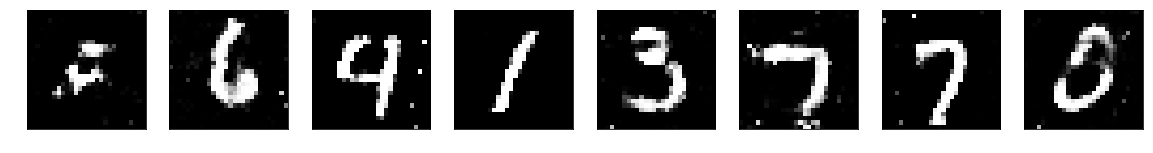

batch 0 100 200 300 400 500 
epoch: 1 	d_err: 1.229 	g_err: 0.971
batch 0 100 200 300 400 500 
epoch: 2 	d_err: 1.243 	g_err: 0.953
batch 0 100 200 300 400 500 
epoch: 3 	d_err: 1.24 	g_err: 0.952
batch 0 100 200 300 400 500 
epoch: 4 	d_err: 1.238 	g_err: 0.965
batch 0 100 200 300 400 500 
epoch: 5 	d_err: 1.237 	g_err: 0.952


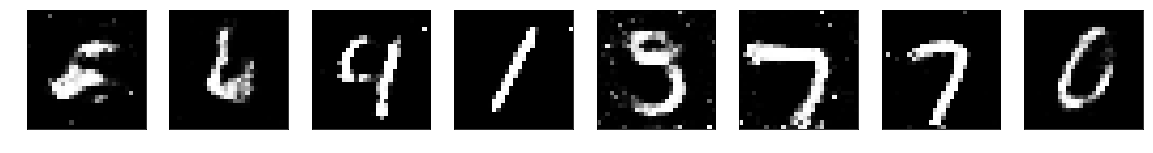

batch 0 100 200 300 400 500 
epoch: 6 	d_err: 1.238 	g_err: 0.953
batch 0 100 200 300 400 500 
epoch: 7 	d_err: 1.239 	g_err: 0.971
batch 0 100 200 300 400 500 
epoch: 8 	d_err: 1.238 	g_err: 0.958
batch 0 100 200 300 400 500 
epoch: 9 	d_err: 1.25 	g_err: 0.944
batch 0 100 200 300 400 500 
epoch: 10 	d_err: 1.246 	g_err: 0.954


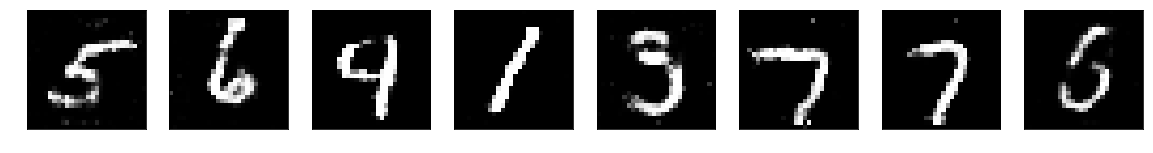

In [47]:
n_epoch = 11

for epoch in range(n_epoch):
    sum_loss_d = 0
    sum_loss_g = 0
    print('batch', end=' ')
    for n_batch, (real_batch, _) in enumerate(data_loader):
        if n_batch % 100 is 0:
            print(n_batch, end=' ')
            
        n = real_batch.size(0)
        
        #train discriminator
        real_data = Variable(real_batch.view(real_batch.size(0), -1))
        fake_data = generator(noise(n)).detach()
        
        d_err, d_pred_real, d_pred_fake \
            = train_discriminator(d_opt, real_data, fake_data)
        
        #train generator
        fake_data = generator(noise(n))
        g_err = train_generator(g_opt, fake_data)
        
        sum_loss_d += d_err.data.item()
        sum_loss_g += g_err.data.item()
        
    print('\nepoch:', epoch, '\td_err:', round(sum_loss_d / num_batches, 3), '\tg_err:', 
          round(sum_loss_g / num_batches, 3))
    
    if epoch % 5 is 0:
        show_results(test_noise)
        plt.show()